## Image Classification Problems - Warm-Up

In the following set of tutorials, we will focus on a particular class of problems, namely supervised classification, as a typical example for machine learning application use cases. Generally, in classification the task is to assign data items to a fixed set of categories, or in other words classes. While this might sound like an easy task for trivial problems such as deciding if someone is of legal age given their birthday, other classification problems are much harder. Consider for example the problem of identifying in a gray-scale satellite image, what land-cover type, e.g. road, house, field, etc., one can see. There are a number of challenges involved in this problem, objects may have different shapes, might be partially covered by cloud shadows or simply have varying colors. Writing a rule-based algorithm for such a problem is close to impossible.

Therefore, we would want to employ a data-driven approach instead and stochastically infer reasonable respresentations for each data-item and class from manually annotated examples (the supervisor). This approach is so flexible that it can be mapped to a large number of application scenarios by providing input data with its corresponding encoded pattern labels (i.e. the annotations). As part of this tutorial, we will study one examplery use case - image classification. For a number of images, we will predict, what object is depicted in it.

For teaching purposes, we will use the battle-test MNIST database [1]. It contains 70.000 images with 28x28 pixels of hand-written digits, collected by US-American National Institute of Standard and Technology. The classification task is to decide what digit can be seen in each of these images. You should notice throughout the tutorial session that the presented approaches can be easily transferred to other application domains, like for example the initially presented satellite image scenario.

### Setup

In line with the presented tutorial series, we will make use of the Python programming language and a number of additionally downloadable packages. Some of you might already be familiar with these, so you might want to skip ahead to the next section.

For those of you that are new to Python, you might an enjoy a (very) brief overview of the packages, we are going to use:

* **h5py [3]** - a module that allows us to process HDF5 [2] files.
* **numpy [4]** - a library for efficient manipulation of multi-dimensional arrays, matrices and mathemical operations.
* **matplotlib [5]** - a plotting library, which we will use to create 2D plots and display images.

In [30]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

### Loading the Data

The entire MNIST database of images including labels is approximately 220 MB in size. During the tutorials you are going to work on the entire dataset. For pratical purposes we have stored the images and labels in an HDF5 file. This is a specifialized data format that originates from the area of high-performance computing (HPC). It is highly optimized for scenarios in which large amounts of data are read and write from disk (potentially in parallel).

HDF5 is particular suited for (semi-)structured data, like vector, matrices or other multi-dimensional arrays. Moreover, HDF5 also provides advanced compressing algorithms reducing the effective size of the MNIST database on disk to roughly 18 MB. At the same time the access to HDF5 files is straight-forward. Within each HDF5 file there is a structure akin to a file-system and its pathes under which data can be stored, respectively read. In our HDF5 file the images of the MNIST dataset can be found in the path (it is actually called a dataset) 'data' and the labels in the dataset 'labels'.

In [50]:
def load_data(path='mnist.h5'):
    """
    Loads a dataset and its supervisor labels from the HDF5 file specified by the path.
    It is assumed that the HDF5 dataset containing the data is called 'data' and the labels are called 'labels'.

    Parameters
    ----------
    path : str, optional
        The absolute or relative path to the HDF5 file, defaults to mnist.h5.

    Returns
    -------
    data_and_labels : tuple(np.array[samples, width, height], np.array[samples])
        a tuple with two numpy array containing the data and labels
    """
    with h5py.File(path, 'r') as handle:
        return np.array(handle['/data']), np.array(handle['/labels'])
    
data, labels = load_data()
data.shape, labels.shape

((70000, 28, 28), (70000,))

### Getting Familiar with the MNIST Dataset

Let's have a look on some of the images, to get a feel for what they look like. Each of them has only a single color gray channel, i.e. is black-and-white.

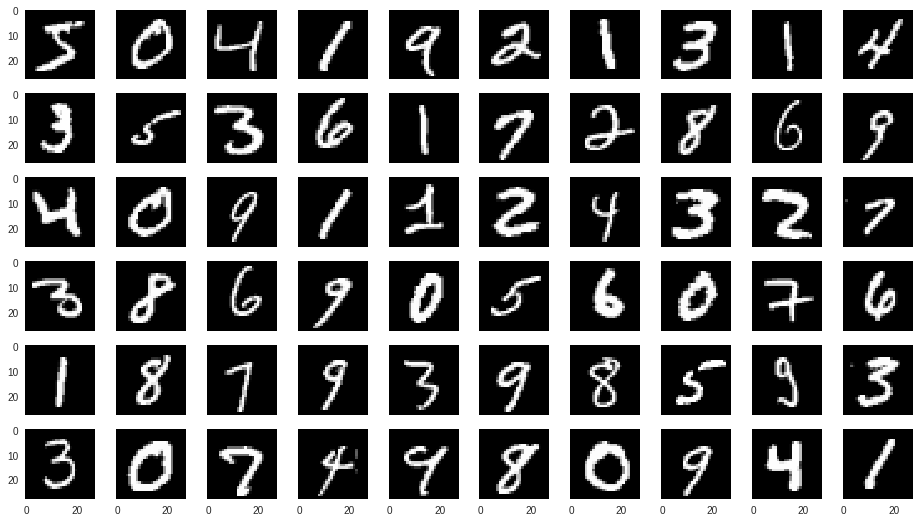

In [55]:
def show_examples(data, width=10, height=6):
    """
    Displays a number of example images from a given dataset. 
    The images are arranged in a rectangular grid with a specified width and height.

    Parameters
    ----------
    data : np.array[samples, width, height]
        The dataset containing the images.
    width : int, optional
        How wide the rectangular image grid shall be, defaults to ten.
    height : int, optional
        How high the rectangular image grid shall, defaults to six.
    """
    index = 0
    figure, axes = plt.subplots(height, width, figsize=(16, 9), sharex=True, sharey=True)
    
    for h in range(height):
        for w in range(width):
            axis = axes[h][w]
            axis.grid(False)
            axis.imshow(data[index], cmap='gist_gray')
            index += 1
    plt.show()

show_examples(data)

### A Slightly Deeper Look

In data-driven application use cases it is usually beneficial to get understanding about the properties of the utilized datasets. This is not only necessary to preprocess the data properly, e.g. clean missing values or normalize each of the feature axis to be on the same scale, but also to be able to fine-tune the machine learning algorithm parameters.

The MNIST dataset is fortunately nicely preprocessed and each feature, i.e. the pixel values, are all within the same range. Therefore, we do not need for the sake of this tutorial to perform any further preprocessing. However, it would be good see whether some of the patterns, meaning the digits, are underrepresented. If so, this would not only mean that we should pay close attention, how we evaluate the model, but also, how effective each of the classes may be learned. Let's have a look.

In [49]:
def count_digits(labels):
    """
    Counts how often each of the individual labels, i.e. each digit, occurs in the dataset.

    Parameters
    ----------
    labels : np.array[samples]
        The labels for each data item.
        
    Returns
    -------
    counts : dict[unique_classes -> int]
        A mapping between each unique class label and its absolute occurrence count.
    """
    return dict(enumerate(np.bincount(labels)))

count_digits(labels)

{0: 6903,
 1: 7877,
 2: 6990,
 3: 7141,
 4: 6824,
 5: 6313,
 6: 6876,
 7: 7293,
 8: 6825,
 9: 6958}

All of the classes seem to be more or less evenly distributed. We can only observe a slight bias towards the digits *1*, *3* and *7* as well as a slight underrepresentation of number *5*. Including more samples depicting *1* and *7* seems like a logical precaution due to their similarity. In practice, we must later carefully investigate how much this skew affects our machine learning model performance.

Since all of the images of the digits in the MNIST database are centered and only have a single color channel, we should be able to compute an "average" digits for each of them.

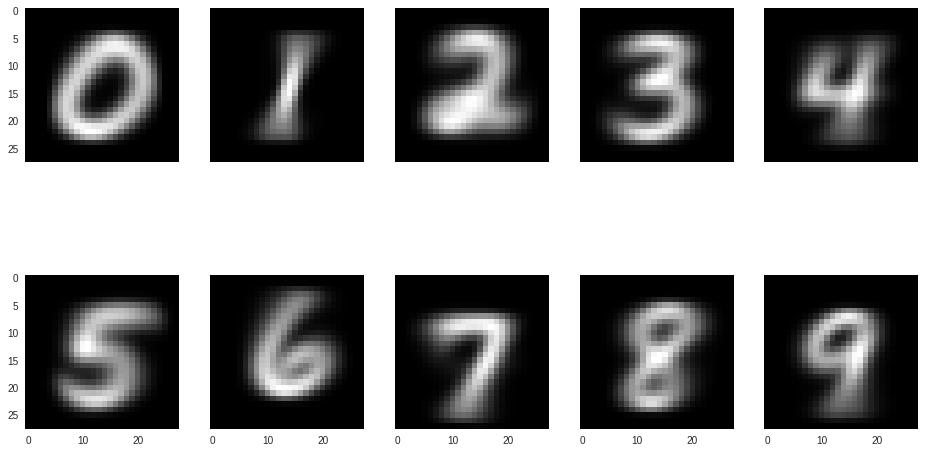

In [52]:
def average_images(data, labels):
    """
    Averages all the data items that are of the same class and returns the resulting 'mean items'.
    
    Parameters
    ----------
    data : np.array[samples, width, height]
        The dataset containing the images.
    labels : np.array[samples]
        The corresponding labels for each data item.
        
    Returns
    -------
    mean_items : np.array[unique_classes, width, height]
        The 'mean items' for each unique class in the labels
    """
    classes = np.unique(labels).shape[0]
    averages = np.zeros((classes, data.shape[1], data.shape[2],))
    
    for digit in range(classes):
        averages[digit] = data[labels == digit].mean(axis=0)
        
    return averages

show_examples(average_images(data, labels), width=5, height=2)

The average numbers still clearly resemble their corresponding individuals. Some of them are a little more fuzzy than others so, e.g. *4* or *9*, highlighting the sample variance and the necessity for a stochastic learning approach. Moreover, one can also clearly see that the digits are American-styled, e.g. missing diagonal slash for the *1* or cross bar for the *7*.

### References

[1] **The MNIST database of handwritten digits**, *Yann LeCun, Corinna Cortes, Christopher J. C. Burges*, [external link](http://yann.lecun.com/exdb/mnist/).

[2] **Hierarchical Data Format, version 5**, *The HDF Group*, [external link](http://www.hdfgroup.org/HDF5/).

[3] **HDF5 for Python**, *Andrew Collette*, O'Reilly, (2008), [documentation, external link](http://docs.h5py.org/en/latest/index.html).

[4] **A guide to NumPy**, *Travis E, Oliphant*, Trelgol Publishing, (2006), [documentation, external link](https://docs.scipy.org/doc/numpy-1.14.0/).

[5] **Matplotlib: A 2D graphics environment**, *John D. Hunter, J. D.*, Computing In Science & Engineering, vol. 9, issue 3, 90-95, (2007), [documentation, external link](https://matplotlib.org/).